In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# For integrated gradients
from tf_explain.core import IntegratedGradients

In [19]:
###############################################################################
# 1. Load and prepare the dataset
###############################################################################
df = pd.read_csv("lr_dataset6.csv")

# Example numeric features. Adjust as needed.
numeric_features = [
    "lambda_list", "lambda_length","lambda_conjugate", "lambda_durfee", "lambda_area", "lambda_lattice",
    "mu_list", "mu_length", "mu_conjugate", "mu_durfee", "mu_area", "mu_lattice",
    "nu_list", "nu_length", "nu_conjugate", "nu_durfee", "nu_area", "nu_lattice"
]

# Convert to numeric and fill NaNs
for col in numeric_features:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

# Binary target: 1 if LR coefficient is nonzero, else 0
df["target"] = (df["lr_coefficient"] > 0).astype(int)

# 3. Split the DataFrame itself into train_data and test_data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Optional: reset the indices so that sample_idx=0 corresponds to the first row in test_data
test_data = test_data.reset_index(drop=True)

# 4. Now you can build X_train, y_train, etc. from train_data, and X_test, y_test from test_data
X_train = train_data[numeric_features]
y_train = train_data["target"]
X_test = test_data[numeric_features]
y_test = test_data["target"]

# Optionally scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:

###############################################################################
# 2. Define a simple feature-wise attention layer
###############################################################################
class FeatureWiseAttention(layers.Layer):
    """
    A simple attention mechanism that learns a scalar weight for each feature.
    We apply a softmax to these weights and then compute a weighted sum
    across the feature dimension.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        # We'll learn one weight per input feature
        self.attention_logits = self.add_weight(
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True,
            name='attention_logits'
        )
        super().build(input_shape)

    def call(self, inputs):
        # inputs shape: (batch_size, num_features)
        # self.attention_logits shape: (num_features,)
        # Convert logits -> normalized attention weights
        alpha = tf.nn.softmax(self.attention_logits)  # shape (num_features,)
        # Weighted sum over the features
        # Expand alpha to match (batch_size, num_features)
        alpha_broadcast = tf.reshape(alpha, (1, -1))
        weighted_sum = tf.reduce_sum(inputs * alpha_broadcast, axis=-1, keepdims=True)
        return weighted_sum  # shape: (batch_size, 1)


In [21]:

###############################################################################
# 3. Build the neural network with attention
###############################################################################
input_dim = X_train_scaled.shape[1]

inputs = layers.Input(shape=(input_dim,))
# [batch_size, input_dim]

# Pass the raw features into the attention layer
attention_output = FeatureWiseAttention()(inputs)
# shape: (batch_size, 1)

# Concatenate the original features and the attention output
concat = layers.Concatenate()([inputs, attention_output])
# shape: (batch_size, input_dim + 1)

# Feed-forward network
hidden = layers.Dense(32, activation='relu')(concat)
hidden = layers.Dense(16, activation='relu')(hidden)
output = layers.Dense(1, activation='sigmoid')(hidden)

model = models.Model(inputs=inputs, outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_wise_atten… │ (None, 1)         │         18 │ input_layer_2[0]… │
│ (FeatureWiseAttent… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 19)        │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ feature_wise_att… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │        640 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │        528 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         17 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,203 (4.70 KB)

 Trainable params: 1,203 (4.70 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:

###############################################################################
# 4. Train the model
###############################################################################
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
168320/168320 ━━━━━━━━━━━━━━━━━━━━ 73s 424us/step - accuracy: 0.8060 - loss: 0.3704 - val_accuracy: 0.8184 - val_loss: 0.3422
Epoch 2/10
168320/168320 ━━━━━━━━━━━━━━━━━━━━ 158s 936us/step - accuracy: 0.8189 - loss: 0.3395 - val_accuracy: 0.8211 - val_loss: 0.3346
Epoch 3/10
168320/168320 ━━━━━━━━━━━━━━━━━━━━ 73s 433us/step - accuracy: 0.8208 - loss: 0.3345 - val_accuracy: 0.8228 - val_loss: 0.3334
Epoch 4/10
168320/168320 ━━━━━━━━━━━━━━━━━━━━ 71s 419us/step - accuracy: 0.8228 - loss: 0.3317 - val_accuracy: 0.8248 - val_loss: 0.3279
Epoch 5/10
168320/168320 ━━━━━━━━━━━━━━━━━━━━ 72s 425us/step - accuracy: 0.8253 - loss: 0.3279 - val_accuracy: 0.8264 - val_loss: 0.3269
Epoch 6/10
168320/168320 ━━━━━━━━━━━━━━━━━━━━ 78s 465us/step - accuracy: 0.8280 - loss: 0.3243 - val_accuracy: 0.8297 - val_loss: 0.3221
Epoch 7/10
168320/168320 ━━━━━━━━━━━━━━━━━━━━ 71s 423us/step - accuracy: 0.8307 - loss: 0.3210 - val_accuracy: 0.8323 - val_loss: 0.3183
Epoch 8/10
168320/168320 ━━━━━━━━━━━━━━━

In [14]:



###############################################################################
# 5. Evaluate the model
###############################################################################
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
test_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_acc)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Accuracy: 0.6705882352941176


Numeric features for sample 0 in the test set:
lambda_list = 0.0
lambda_length = 6
lambda_conjugate = 0.0
lambda_durfee = 4
lambda_area = 24
lambda_lattice = 1111110000
mu_list = 0.0
mu_length = 5
mu_conjugate = 0.0
mu_durfee = 3
mu_area = 20
mu_lattice = 101001110001
nu_list = 0.0
nu_length = 2
nu_conjugate = 0.0
nu_durfee = 1
nu_area = 4
nu_lattice = 100101111

Partition-related columns for sample 0:
lambda_list = 0.0
mu_list = 0.0
nu_list = 0.0
lr_coefficient = 0

Full row data:
lambda_list                                  0.0
lambda_length                                  6
lambda_conjugate                             0.0
lambda_durfee                                  4
lambda_area                                   24
lambda_frobenius    ([3, 2, 1, 0], [5, 4, 3, 2])
lambda_lattice                        1111110000
mu_list                                      0.0
mu_length                                      5
mu_conjugate                                 0.0
mu_durfee              

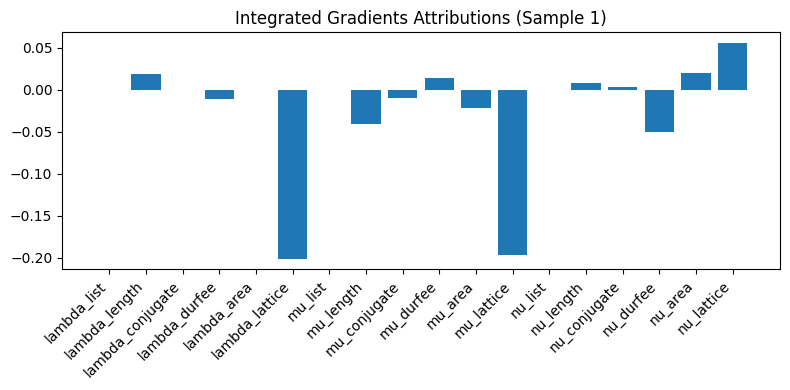

In [24]:
###############################################################################
# 6. Integrated Gradients for Interpretability
###############################################################################
def integrated_gradients(model, x, baseline=None, steps=50):
    """
    Computes Integrated Gradients for a given model and input x.
    
    Args:
        model: A tf.keras.Model.
        x: Input tensor of shape (batch_size, input_dim).
        baseline: Baseline tensor of same shape as x (if None, uses zeros).
        steps: Number of interpolation steps.
    
    Returns:
        Integrated gradients tensor of shape (batch_size, input_dim).
    """
    if baseline is None:
        baseline = tf.zeros_like(x)
    
    # Generate interpolation coefficients between baseline and x.
    alphas = tf.linspace(0.0, 1.0, steps+1)  # shape: (steps+1,)
    alphas = tf.reshape(alphas, (steps+1, 1, 1))  # shape: (steps+1, 1, 1)
    
    # Expand x and baseline for interpolation.
    x_expanded = tf.expand_dims(x, 0)          # shape: (1, batch_size, input_dim)
    baseline_expanded = tf.expand_dims(baseline, 0)  # shape: (1, batch_size, input_dim)
    interpolated = baseline_expanded + alphas * (x_expanded - baseline_expanded)
    # interpolated shape: (steps+1, batch_size, input_dim)
    
    # Reshape to combine steps and batch.
    steps_plus_batch = (steps+1) * tf.shape(x)[0]
    interpolated = tf.reshape(interpolated, (steps_plus_batch, x.shape[1]))
    
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = model(interpolated)
    grads = tape.gradient(preds, interpolated)
    
    # Reshape grads back to (steps+1, batch_size, input_dim)
    grads = tf.reshape(grads, (steps+1, tf.shape(x)[0], x.shape[1]))
    # Average gradients across steps.
    avg_grads = tf.reduce_mean(grads, axis=0)  # shape: (batch_size, input_dim)
    integrated_grads = (x - baseline) * avg_grads
    return integrated_grads

# Pick a sample from the test set.
sample_idx = 1
sample_input = tf.convert_to_tensor(X_test_scaled[sample_idx:sample_idx+1], dtype=tf.float32)
baseline = tf.zeros_like(sample_input)

ig_attributions = integrated_gradients(model, sample_input, baseline=baseline, steps=50)
ig_np = ig_attributions.numpy()[0]

# Print all numeric features for this row
print("Numeric features for sample 0 in the test set:")
for col in numeric_features:
    val = test_data.loc[sample_idx, col]
    print(f"{col} = {val}")

# Print other relevant columns, e.g. the original partition strings
print("\nPartition-related columns for sample 0:")
for col in ["lambda_list", "mu_list", "nu_list", "lr_coefficient"]:
    if col in test_data.columns:
        val = test_data.loc[sample_idx, col]
        print(f"{col} = {val}")

# If you want to see the entire row, just print test_data.iloc[sample_idx]:
print("\nFull row data:")
print(test_data.iloc[sample_idx])


print("Integrated Gradients attributions for sample index", sample_idx)
for feat_name, val in zip(numeric_features, ig_np):
    print(f"{feat_name}: {val:.4f}")

# Plot a bar chart of attributions.
plt.figure(figsize=(8,4))
plt.bar(range(len(numeric_features)), ig_np)
plt.xticks(range(len(numeric_features)), numeric_features, rotation=45, ha='right')
plt.title(f"Integrated Gradients Attributions (Sample {sample_idx})")
plt.tight_layout()
plt.show()

In [23]:
def compute_ig_for_dataset(model, X, baseline=None, steps=50):
    """
    Compute integrated gradients for every sample in X.
    Returns a numpy array of shape (num_samples, num_features).
    """
    all_ig = []
    for i in range(len(X)):
        x_input = X[i:i+1]  # shape (1, num_features)
        x_input_tensor = tf.convert_to_tensor(x_input, dtype=tf.float32)
        if baseline is None:
            baseline_tensor = tf.zeros_like(x_input_tensor)
        else:
            baseline_tensor = tf.convert_to_tensor(baseline[i:i+1], dtype=tf.float32)
        
        ig = integrated_gradients(model, x_input_tensor, baseline_tensor, steps=steps)
        all_ig.append(ig.numpy()[0])  # shape (num_features,)
    
    return np.stack(all_ig)  # shape (num_samples, num_features)

# 1. Compute IG for every sample in the test set
ig_values = compute_ig_for_dataset(model, X_test_scaled, baseline=None, steps=50)
# ig_values.shape = (len(X_test_scaled), num_features)

# 2. Aggregate the attributions. For example, the mean absolute IG:
mean_abs_ig = np.mean(np.abs(ig_values), axis=0)

# 3. Visualize
plt.figure(figsize=(8,4))
plt.bar(range(len(numeric_features)), mean_abs_ig)
plt.xticks(range(len(numeric_features)), numeric_features, rotation=45, ha='right')
plt.title("Mean Absolute Integrated Gradients (Test Set)")
plt.tight_layout()
plt.show()

# Optionally, you can also compute raw mean to see net positive vs negative:
mean_raw_ig = np.mean(ig_values, axis=0)
print("Mean (raw) IG across test set:", mean_raw_ig)


KeyboardInterrupt: 